# 1. How does the value of img_size affect training time?

The value of img_size affects the training time of Transformers for Vision in several ways. First, the larger the img_size, the more pixels and features the model has to process, which increases the computational complexity and memory consumption. Second, the larger the img_size, the more data augmentation and preprocessing steps are needed, which also adds to the training time. Third, the larger the img_size, the more likely the model is to overfit or underfit the data, which may require more epochs or fine-tuning to achieve optimal performance ¹.

Therefore, choosing an appropriate img_size is important for balancing the trade-off between accuracy and efficiency of Transformers for Vision. According to some experiments ², a patch size of 4 resulted in the best performance on the CIFAR10 dataset, while a patch size of 8 was more suitable for ImageNet. However, this may not be true for all tasks and datasets, and there may be other ways to improve the computational and memory efficiency of Transformers for Vision, such as using chunked attention, sparse attention, or sliding window attention ¹.

- (1) Tutorial 11: Vision Transformers — PyTorch Lightning 2.0.8 .... https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/11-vision-transformer.html.
- (2) GitHub - lucidrains/vit-pytorch: Implementation of Vision .... https://github.com/lucidrains/vit-pytorch.
- (3) Rethinking Vision Transformers for MobileNet Size and Speed. https://arxiv.org/abs/2212.08059.

# 2. Instead of projecting the cls token representation to the output, how would you project the averaged patch representations? Implement this change and see how it affects the accuracy.

We can use the mean of the patch representations along the sequence dimension to replace the cls token representation

In [1]:
import sys
import torch.nn as nn
import torch
import warnings
from sklearn.model_selection import ParameterGrid
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
warnings.filterwarnings("ignore")

In [2]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (
            img_size[1] // patch_size[1])
        self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size,
                                  stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).flatten(2).transpose(1, 2)
    
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(
            self.dense1(x)))))
    
class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens,
                 num_heads, dropout, use_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape)
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.ln2 = nn.LayerNorm(norm_shape)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens=None):
        X = X + self.attention(*([self.ln1(X)] * 3), valid_lens)
        return X + self.mlp(self.ln2(X))

class ViT(d2l.Classifier):
    """Vision Transformer."""
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1,
                 use_bias=False, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(
            img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # Add the cls token
        # Positional embeddings are learnable
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_steps, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock(
                num_hiddens, num_hiddens, mlp_num_hiddens,
                num_heads, blk_dropout, use_bias))
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens),
                                  nn.Linear(num_hiddens, num_classes))

    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
        return self.head(X[:, 0])

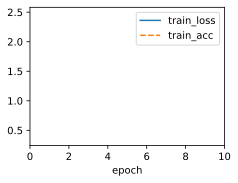

In [ ]:
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))
trainer.fit(model, data)

# 3. Can you modify hyperparameters to improve the accuracy of the vision Transformer?